The visualizations on the datasets:
1. Emission trend graphs for each emission element
2. Production trend graphs for each production item/forest product
3. Distribution of forestry products
4. Distribution of production crops
5. Distribution of emissions and emission types

In [1]:
import io
import boto3
import pandas as pd

def read_datasets():
    # Read three datasets stored in the Amazon S3 bucket
    bucket = "faostat-ml"
    file_name = "filtered_files/Emissions_Totals_E_All_Data_(Normalized).csv"
    s3_client = boto3.client("s3")
    obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_emission = pd.read_csv(io.BytesIO(obj['Body'].read()))
    df_emission.drop(df_emission.columns[df_emission.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

    #fix the feature names
    df_emission = df_emission.rename(columns={'Item': 'EmissionItem','Value': 'EmissionValue','Element': 'EmissionElement','Unit': 'EmissionUnit'})
    print(df_emission.head(5))

    file_name = "filtered_files/Production_Crops_Livestock_E_All_Data_(Normalized).csv"
    obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_prod = pd.read_csv(io.BytesIO(obj['Body'].read()))
    df_prod.drop(df_prod.columns[df_prod.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_prod.drop('Unit', axis=1, inplace=True)
    print(df_prod.head(5))


    file_name = "filtered_files/Forestry_E_All_Data_(Normalized).csv"
    obj = s3_client.get_object(Bucket=bucket, Key=file_name)
    df_forest = pd.read_csv(io.BytesIO(obj['Body'].read()),encoding='latin-1')
    df_forest.drop(df_forest.columns[df_forest.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    print(df_forest.head(5))
    return df_emission, df_prod, df_forest

In [8]:
def pre_processing():
    remove_rows_df = pre_process_df.copy()
    
    # Removes area, source and emission unit that place no significant role
    remove_rows_df.drop('Area', axis=1, inplace=True)
    remove_rows_df.drop('Source', axis=1, inplace=True)
    remove_rows_df.drop('EmissionUnit', axis=1, inplace=True)
    
    # Remove redudant instance
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Area harvested"]
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Production"]
    remove_rows_df = remove_rows_df[remove_rows_df.Element != "Producing Animals/Slaughtered"]
    remove_rows_df = remove_rows_df[remove_rows_df.EmissionElement != "Indirect emissions (N2O)"]
    remove_rows_df = remove_rows_df[remove_rows_df.EmissionElement != "Direct emissions (N2O)"]
    remove_rows_df.index = remove_rows_df.Year
    remove_rows_df.drop('Year', axis=1, inplace=True)

    #identify partial string to look for
    discard = ['from']
    remove_rows_df = remove_rows_df[~remove_rows_df.EmissionElement.str.contains('|'.join(discard))]

    # Combine two features
    remove_rows_df["Emission"] = remove_rows_df["EmissionItem"] + str("_") + remove_rows_df["EmissionElement"]
    remove_rows_df.drop('EmissionItem', axis=1, inplace=True)
    remove_rows_df.drop('EmissionElement', axis=1, inplace=True)

    # Remove redudant instance
    remove_rows_df = remove_rows_df[remove_rows_df.Element != 'Import Value']
    remove_rows_df = remove_rows_df[remove_rows_df.Element != 'Export Value']
    
    emission_list = list(pre_process_df.EmissionItem.unique())

    # Create pivot table for production items + forestry products based on year and item
    df_item = remove_rows_df.pivot_table(index=['Year'], 
                columns=['Item'], values='Value')
    
    # Remove columns that have atleast one NaN value since it would affect the forecast
    sum = df_item.isnull().sum(axis = 0)
    for items in sum.iteritems():
        if(items[1]>0):
            df_item.drop(items[0], axis=1, inplace=True)
    nan_cols = [i for i in df_item.columns if df_item[i].isnull().any()]

    # Create pivot table for emissions
    df_emi = remove_rows_df.pivot_table(index=['Year'], 
                columns=['Emission'], values='EmissionValue')
    # Remove columns that have atleast one NaN value since it would affect the forecast
    sum = df_emi.isnull().sum(axis = 0)
    for items in sum.iteritems():
        if(items[1]>0):
            df_emi.drop(items[0], axis=1, inplace=True)
    nan_cols = [i for i in df_emi.columns if df_emi[i].isnull().any()]
    
    display(df_item.head(5))
    display(df_emi.head(5))
    return df_item, df_emi, emission_list

In [2]:
def plot_emissions():
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df_emi[df_emi.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(df_emi.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();

In [3]:
def plot_productionitems():
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=4, ncols=3, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        data = df_item[df_item.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        # Decorations
        ax.set_title(df_item.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();

In [4]:
def time_series_prediction():
    pre_process_df = pd.DataFrame()
    combined_df = pd.DataFrame()

    import numpy as np
    import seaborn as sb
    import ipywidgets as widgets
    import matplotlib.pyplot as plt
    from sklearn import preprocessing
    from sklearn.preprocessing import LabelEncoder
    from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider

    def unique_sorted_values_plus_ALL(array):
        unique = array.unique().tolist()
        unique.sort()
        return unique
    output_area = widgets.Output()
    print("Area:")
    dropdown_area = widgets.Dropdown(options=unique_sorted_values_plus_ALL(df_prod.Area))
    def dropdown_area_eventhandler(change):
        output_area.clear_output()
        with output_area:
            if(change.new):
                country_df_prod = df_prod[df_prod.Area == change.new]
                country_df_forest = df_forest[df_forest.Area == change.new]
                country_df_emission = df_emission[df_emission.Area == change.new]

                prod_forest_df = pd.concat([country_df_prod, country_df_forest], ignore_index=True)
                global pre_process_df, combined_df
                pre_process_df = pd.merge(prod_forest_df, country_df_emission, on=['Year','Area'])
    dropdown_area.observe(dropdown_area_eventhandler, names='value')
    display(dropdown_area)

In [5]:
# Run the functions from this module onwards for time series prediction
df_emission, df_prod, df_forest = read_datasets()

          Area          EmissionItem  EmissionElement  Year      Source  \
0  Afghanistan  Enteric Fermentation  Emissions (CH4)  1961  FAO TIER 1   
1  Afghanistan  Enteric Fermentation  Emissions (CH4)  1962  FAO TIER 1   
2  Afghanistan  Enteric Fermentation  Emissions (CH4)  1963  FAO TIER 1   
3  Afghanistan  Enteric Fermentation  Emissions (CH4)  1964  FAO TIER 1   
4  Afghanistan  Enteric Fermentation  Emissions (CH4)  1965  FAO TIER 1   

  EmissionUnit  EmissionValue  
0   kilotonnes       240.6831  
1   kilotonnes       245.3106  
2   kilotonnes       255.8285  
3   kilotonnes       259.0650  
4   kilotonnes       265.5980  
          Area                 Item         Element  Year   Value
0  Afghanistan  Almonds, with shell  Area harvested  1975     0.0
1  Afghanistan  Almonds, with shell  Area harvested  1976  5900.0
2  Afghanistan  Almonds, with shell  Area harvested  1977  6000.0
3  Afghanistan  Almonds, with shell  Area harvested  1978  6000.0
4  Afghanistan  Almonds, wi

In [6]:
time_series_prediction()

Area:


Dropdown(options=('Afghanistan', 'Africa', 'Albania', 'Algeria', 'Americas', 'Angola', 'Antigua and Barbuda', …

In [9]:
df_item, df_emi, emission_list = pre_processing()

Item,Agave fibres nes,"Almonds, with shell","Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Asses,Avocados,...,Veneer sheets,Vetches,"Walnuts, with shell",Watermelons,Wheat,Wood charcoal,Wood fuel,Wood pulp,Wood-based panels,Yams
Year,,,,,,,,,,,,,,,,,,,,,
1961,8462.0,17073.0,5554.0,64850.0,34471.0,7127.0,119101.0,25416.0,16372019.0,45409.0,...,24038.5,8658.0,21995.0,117565.0,7486.0,115850.0,159700.0,117750.0,310265.0,87255.0
1962,8194.0,17537.0,5514.0,68007.0,33381.0,6885.0,113918.0,26957.0,15063037.0,45074.0,...,37608.0,8501.0,22457.0,119400.0,8448.0,123725.0,115925.0,141050.0,356068.5,79543.0
1963,8247.0,15168.0,5506.0,73024.0,27217.0,6983.0,111058.0,28299.0,15183296.0,45968.0,...,46673.0,8722.0,22462.0,116409.0,8532.0,112000.0,73849.5,254350.0,411407.0,99741.0
1964,9619.0,16589.0,5610.0,73626.0,33213.0,6915.0,110407.0,27962.0,15577427.0,47689.0,...,70192.5,9472.0,22330.0,120710.0,8431.0,87882.0,90300.0,280600.0,566880.5,108969.0
1965,9268.0,15175.0,5638.0,74239.0,31811.0,6760.0,96002.0,28821.0,16116872.0,49053.0,...,93340.5,9276.0,22652.0,123218.0,9755.0,98850.0,75583.5,272381.5,623491.0,110151.0


Emission,Agricultural Soils_Emissions (CO2eq) (AR5),Agricultural Soils_Emissions (N2O),Burning - Crop residues_Emissions (CH4),Burning - Crop residues_Emissions (CO2eq) (AR5),Burning - Crop residues_Emissions (N2O),Crop Residues_Emissions (CO2eq) (AR5),Crop Residues_Emissions (N2O),Enteric Fermentation_Emissions (CH4),Enteric Fermentation_Emissions (CO2eq) (AR5),IPCC Agriculture_Emissions (CH4),...,Manure Management_Emissions (CO2eq) (AR5),Manure Management_Emissions (N2O),Manure applied to Soils_Emissions (CO2eq) (AR5),Manure applied to Soils_Emissions (N2O),Manure left on Pasture_Emissions (CO2eq) (AR5),Manure left on Pasture_Emissions (N2O),Rice Cultivation_Emissions (CH4),Rice Cultivation_Emissions (CO2eq) (AR5),Synthetic Fertilizers_Emissions (CO2eq) (AR5),Synthetic Fertilizers_Emissions (N2O)
Year,,,,,,,,,,,,,,,,,,,,,
1961,165579.9232,624.8299,306.4455,10685.8668,7.9449,30568.4824,115.3528,18825.8193,527122.9400,36811.6988,...,65611.8249,91.8648,23479.2353,88.6009,100294.0350,378.4681,16205.5889,453756.4904,11238.1705,42.4082
1962,168860.1411,637.2081,307.5017,10722.6995,7.9723,31839.0365,120.1473,18708.9777,523851.3764,37214.2253,...,65268.4716,90.5605,23383.5959,88.2400,100319.4493,378.5640,16723.8195,468266.9451,13318.0594,50.2568
1963,173352.1618,654.1591,312.4578,10895.5195,8.1008,32732.7848,123.5199,18878.9960,528611.8875,37446.9550,...,67706.1641,94.1558,24155.0408,91.1511,101541.6972,383.1762,16728.5412,468399.1545,14922.6389,56.3118
1964,180384.2549,680.6953,324.7525,11324.2394,8.4195,34063.2791,128.5407,19358.3426,542033.5920,38686.3553,...,71906.2975,100.7026,25449.8970,96.0373,103608.2048,390.9744,17388.2565,486871.1813,17262.8740,65.1429
1965,186646.5882,704.3267,324.0673,11300.3478,8.4017,33802.2397,127.5556,19673.3413,550853.5573,39011.8179,...,75078.6113,106.0929,26413.5986,99.6740,105313.3967,397.4090,17337.1234,485439.4554,21117.3532,79.6881


Visualization - 1

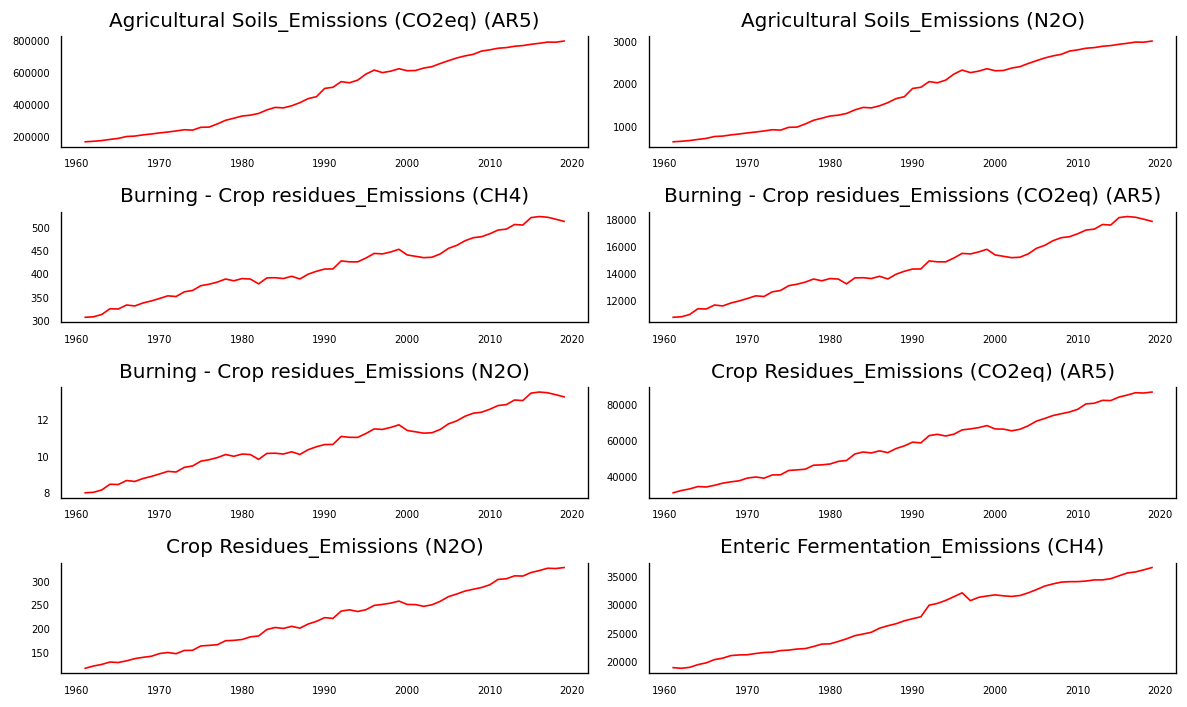

In [10]:
plot_emissions()

Visualization - 2

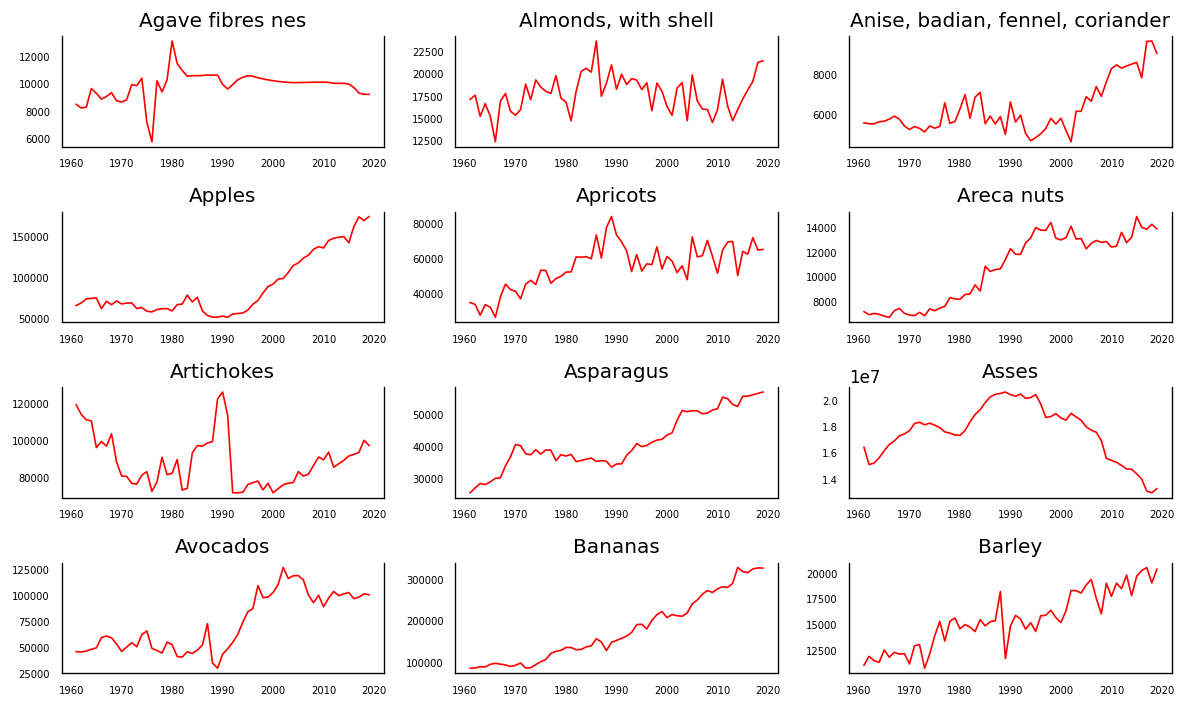

In [11]:
plot_productionitems()

Visualization - 3

,Area,Item,Element,Year,Value
0,Afghanistan,Forest products (export/import),Import Value,1964,301.0
1,Afghanistan,Forest products (export/import),Import Value,1965,321.0
2,Afghanistan,Forest products (export/import),Import Value,1966,435.0
3,Afghanistan,Forest products (export/import),Import Value,1967,466.0
4,Afghanistan,Forest products (export/import),Import Value,1968,297.0


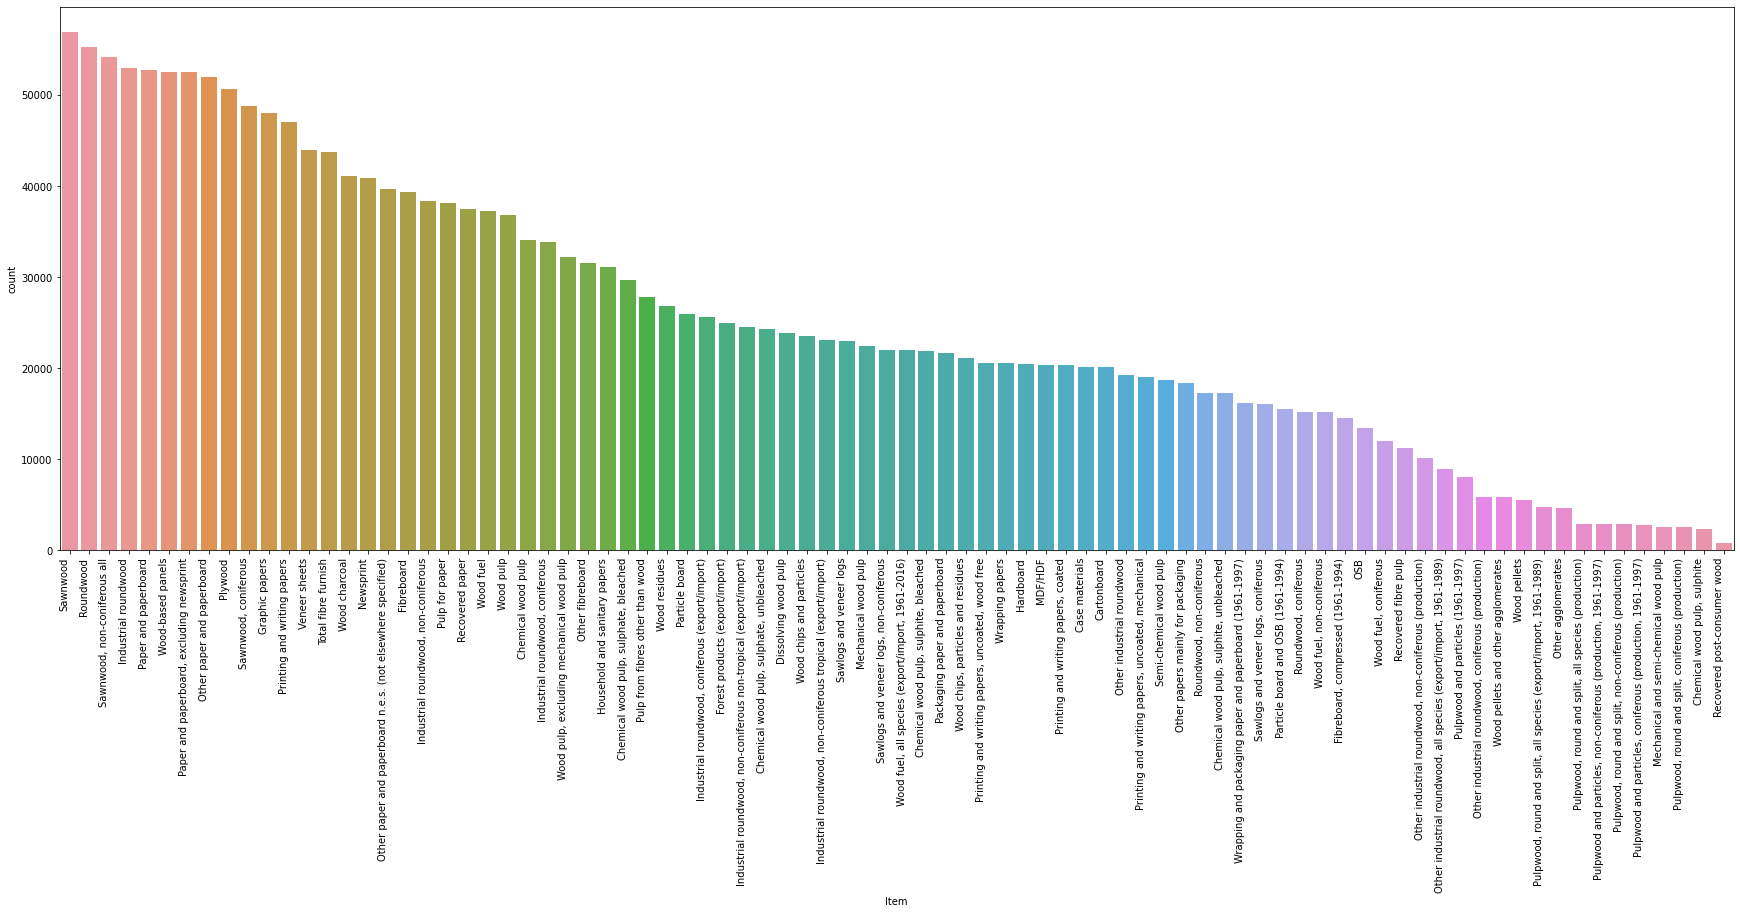

In [13]:
import matplotlib.pyplot as plt

display(df_forest.head(5))
import seaborn as sns
plt.figure(figsize = (30,10))
plot = sns.countplot(x='Item',data=df_forest, order = df_forest['Item'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, ha="right")
plt.show()

Visualization - 4

,Area,Item,Element,Year,Value
0,Afghanistan,"Almonds, with shell",Area harvested,1975,0.0
1,Afghanistan,"Almonds, with shell",Area harvested,1976,5900.0
2,Afghanistan,"Almonds, with shell",Area harvested,1977,6000.0
3,Afghanistan,"Almonds, with shell",Area harvested,1978,6000.0
4,Afghanistan,"Almonds, with shell",Area harvested,1979,6000.0


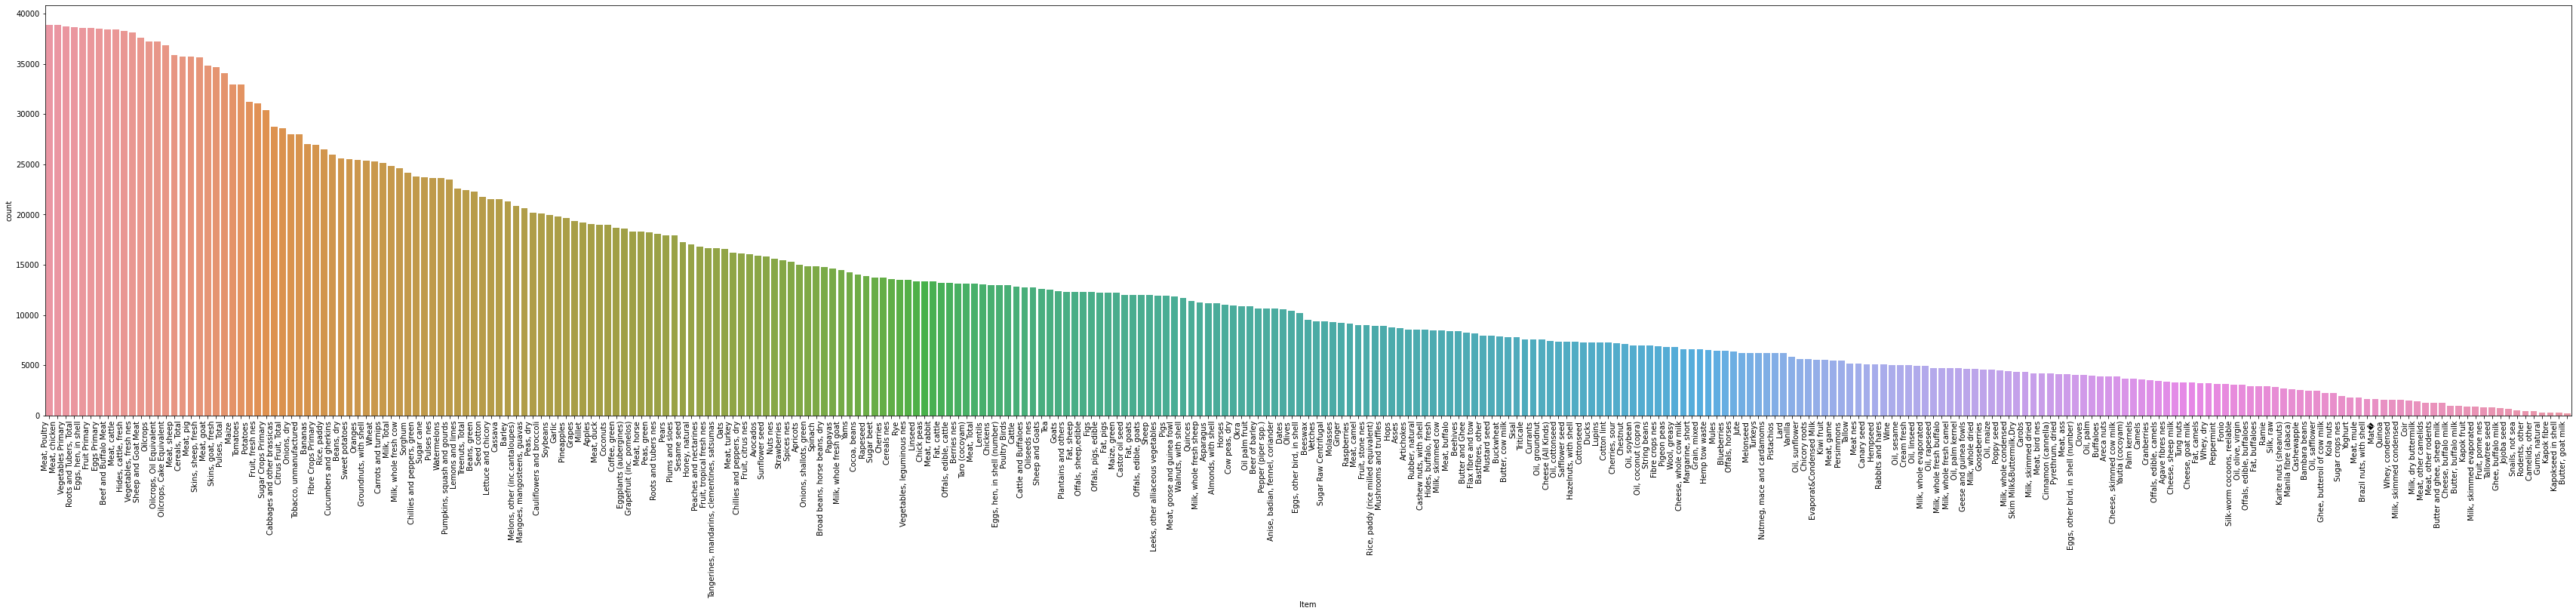

In [14]:
display(df_prod.head(5))

import seaborn as sns
plt.figure(figsize = (60,10))
plot = sns.countplot(x='Item',data=df_prod, order = df_prod['Item'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, ha="right")
plt.show()

Visualization - 5

,Area,EmissionItem,EmissionElement,Year,Source,EmissionUnit,EmissionValue
0,Afghanistan,Enteric Fermentation,Emissions (CH4),1961,FAO TIER 1,kilotonnes,240.6831
1,Afghanistan,Enteric Fermentation,Emissions (CH4),1962,FAO TIER 1,kilotonnes,245.3106
2,Afghanistan,Enteric Fermentation,Emissions (CH4),1963,FAO TIER 1,kilotonnes,255.8285
3,Afghanistan,Enteric Fermentation,Emissions (CH4),1964,FAO TIER 1,kilotonnes,259.0650
4,Afghanistan,Enteric Fermentation,Emissions (CH4),1965,FAO TIER 1,kilotonnes,265.5980


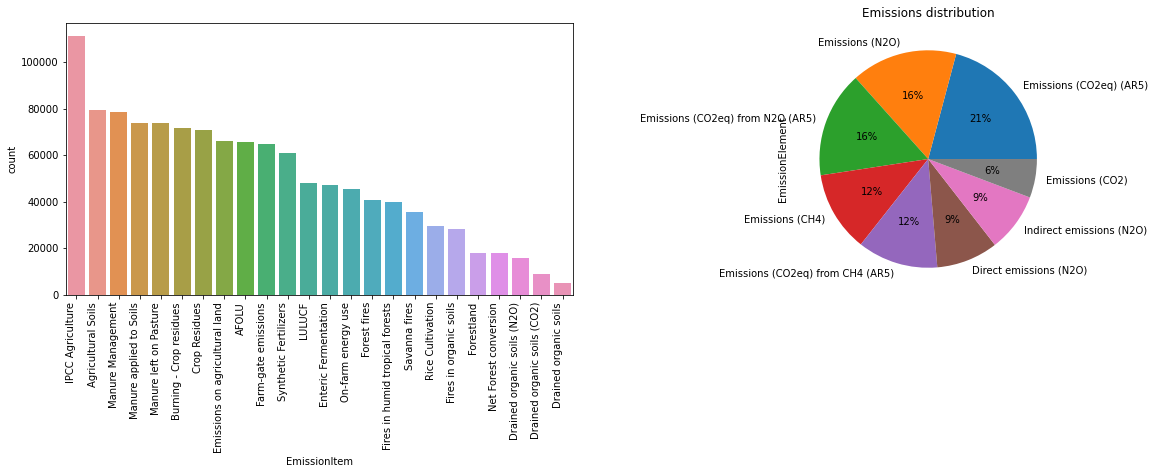

In [15]:
display(df_emission.head(5))

import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
plot = sns.countplot(x='EmissionItem',data=df_emission, order = df_emission['EmissionItem'].value_counts().index, ax = ax1)
df_emission['EmissionElement'].value_counts().plot.pie(autopct='%1.0f%%', ax = ax2).set_title('Emissions distribution')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, ha="right")
plt.show()